## Content 
[Library Imports](#-Library_Imports)

[Data Loading and Initial Inspection](#-Data_Loading_and_Initial_Inspection)

[Data Preprocessing](#-Data_Preprocessing)

[TimeStamp processing](#-TimeStamp_processing)

[sentiment preprocessed](#-sentiment_preprocessed)

[building models](#-building_models)

[Sentiment analysis](#-Sentiment_analysis)

[Word Cloud Generation](#-Word_Cloud_Generation)

# Library Imports


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import random 
import re
import nltk 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from nrclex import NRCLex
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer


# To hide warnings
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Initial Inspection.

In [4]:
data=pd.read_csv("simpsons_script_liness.csv")

In [5]:
data

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...
...,...,...,...,...,...,...,...,...,...,...,...,...
158266,9544,32,204,Miss Hoover: (OFF LISA'S REACTION) I'm back.,831000,TRUE,464,3.0,Miss Hoover,Springfield Elementary School,I'm back.,im back
158267,9545,32,205,"Miss Hoover: You see, class, my Lyme disease t...",839000,TRUE,464,3.0,Miss Hoover,Springfield Elementary School,"You see, class, my Lyme disease turned out to ...",you see class my lyme disease turned out to be
158268,9546,32,206,Miss Hoover: Psy-cho-so-ma-tic.,842000,TRUE,464,3.0,Miss Hoover,Springfield Elementary School,Psy-cho-so-ma-tic.,psy-cho-so-ma-tic
158269,9547,32,207,Ralph Wiggum: Does that mean you were crazy?,844000,TRUE,119,3.0,Ralph Wiggum,Springfield Elementary School,Does that mean you were crazy?,does that mean you were crazy


In [6]:
# displaying the number of rows and number of columns 
data.shape

(158271, 12)

In [7]:
# total number of elements (rows X columns)
data.size

1899252

In [8]:
# Displaying the data types of each column 
data.dtypes 

id                      int64
episode_id              int64
number                  int64
raw_text               object
timestamp_in_ms        object
speaking_line          object
character_id           object
location_id           float64
raw_character_text     object
raw_location_text      object
spoken_words           object
normalized_text        object
dtype: object

In [9]:
# checking all epsiode 
len(data["episode_id"].unique())

564

In [10]:
# checking for duplicated rows 
data.duplicated().sum()

0

In [11]:
# Checking for missing values in each column 
data.isnull().sum() 

# we must find code that find the non matching row 

id                        0
episode_id                0
number                    0
raw_text                  0
timestamp_in_ms           0
speaking_line             0
character_id          17521
location_id             407
raw_character_text    17522
raw_location_text       408
spoken_words          26159
normalized_text       26184
dtype: int64

In [12]:
# Identifying rows where 'character_id' column does not match 'raw_character_text' column
extra_row = data[data['character_id'].isnull() ^ data['raw_character_text'].isnull()]

print(extra_row)

            id  episode_id  number  \
142024  152461         546      20   

                                                 raw_text  \
142024  "ABRAHAM LINCOLN: (FURIOUS) Guess what. I also...   

                      timestamp_in_ms                          speaking_line  \
142024  Springfield Elementary School  Guess what. I also play Frankenstein!   

                               character_id  location_id raw_character_text  \
142024  guess what i also play frankenstein          6.0                NaN   

       raw_location_text spoken_words normalized_text  
142024               NaN          NaN             NaN  


## Data Preprocessing

In [13]:
# Null values in 'character_id' column represent scenes (scenes don't have IDs)
# Dropping 'location_id' and 'raw_location_text' columns as they are not important for the analysis
data=data.dropna()
data.drop(columns=['location_id','raw_location_text'],inplace=True)

In [14]:
data.isnull().sum()

id                    0
episode_id            0
number                0
raw_text              0
timestamp_in_ms       0
speaking_line         0
character_id          0
raw_character_text    0
spoken_words          0
normalized_text       0
dtype: int64

In [15]:
# Checking unique values in the "speaking_line" column
data["speaking_line"].unique()

array([True, 'TRUE'], dtype=object)

In [16]:
# Converting 'true' to True in the 'speaking_line' column
data["speaking_line"]= data["speaking_line"].replace("TRUE",True)

In [17]:
# Converting 'true' to True in the 'speaking_line' column
data["speaking_line"].unique()

array([ True])

In [18]:
# Removing the character name from the 'raw_text' column
data['raw_text'] = data['raw_text'].str.split(':', n=1).str[1]

# You can remove parentheses if needed by adding another step:
# data['raw_text'] = data['raw_text'].str.replace(r'\([^()]*\)', '')


In [19]:
# Function to assign season number based on episode number

def assign_season(episode_number):
    if episode_number <= 13:
        return 1
    elif episode_number <= 36:
        return 2
    elif episode_number <= 61:
        return 3
    elif episode_number <= 84:
        return 4
    elif episode_number <= 107:
        return 5
    elif episode_number <= 133:
        return 6
    elif episode_number <= 159:
        return 7
    elif episode_number <= 185:
        return 8
    elif episode_number <= 211:
        return 9
    elif episode_number <= 235:
        return 10
    elif episode_number <= 258:
        return 11
    elif episode_number <= 280:
        return 12
    elif episode_number <= 303:
        return 13
    elif episode_number <= 326:
        return 14
    elif episode_number <= 349:
        return 15
    elif episode_number <= 371:
        return 16
    elif episode_number <= 394:
        return 17
    elif episode_number <= 417:
        return 18
    elif episode_number <= 438:
        return 19
    elif episode_number <= 460:
        return 20
    elif episode_number <= 484:
        return 21
    elif episode_number <= 507:
        return 22
    elif episode_number <= 530:
        return 23
    elif episode_number <= 553:
        return 24
    elif episode_number <= 576:
        return 25
    elif episode_number <= 599:
        return 26
    elif episode_number <= 622:
        return 27
    elif episode_number <= 645:
        return 28
    elif episode_number <= 667:
        return 29
    elif episode_number <= 691:
        return 30
    elif episode_number <= 714:
        return 31
    elif episode_number <= 737:
        return 32
    elif episode_number <= 760:
        return 33
    elif episode_number <= 783:
        return 34
    elif episode_number <= 802:
        return 35
    else: 
        return 0 

# Applying the function to create a new column 'Season'
data['Season'] = data['number'].apply(assign_season)


data['Season']

0          9
1          9
2          9
3         10
4         10
          ..
158266     9
158267     9
158268     9
158269     9
158270     9
Name: Season, Length: 131708, dtype: int64

In [20]:
# Grouping the DataFrame by 'Season'
grouped = data.groupby('Season')

# Accessing the first group from the grouped object
first_group = grouped.get_group(1)

# Displaying the first group
print(first_group)

          id  episode_id  number  \
57      9660          33       5   
84      9661          33       6   
85      9662          33       7   
86      9663          33       8   
112     9656          33       1   
...      ...         ...     ...   
158073  9349          32       9   
158074  9350          32      10   
158075  9351          32      11   
158076  9352          32      12   
158077  9353          32      13   

                                                 raw_text timestamp_in_ms  \
57       (INDIGNANT) Never thrown a party? What about ...           97000   
84                                  That was our wedding.          103000   
85                                                    Oh.          103000   
86       (LOOKS UP) Children, it's time for you to go ...          105000   
112                                  Mmm... hors doovers.           84000   
...                                                   ...             ...   
158073   Malignant spirochet

In [21]:
# Filtering the DataFrame for the four main characters and retrieving their IDs

simpsons = data[data['raw_character_text'].isin(['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson'])].reset_index(drop=True).dropna()
printed = set()
for i, row in simpsons.iterrows():
    if row['raw_character_text'] not in printed:
        print("ID:", row['character_id'], "for", row['raw_character_text'])
        printed.add(row['raw_character_text'])


ID: 9.0 for Lisa Simpson
ID: 8.0 for Bart Simpson
ID: 2.0 for Homer Simpson
ID: 1.0 for Marge Simpson


#### These output  doesnt make any sense :

In [22]:
# Counting the occurrences of each character for character ID 2
data[data["character_id"] == 2]["raw_character_text"].value_counts()


raw_character_text
Homer Simpson       23010
Homer's Brain           1
Homer's Thoughts        1
Young Homer             1
Name: count, dtype: int64

In [23]:
# Counting the occurrences of character IDs for "Homer Simpson"
data[data["raw_character_text"] == "Homer Simpson"]["character_id"].value_counts()

character_id
2.0    23010
2       4834
Name: count, dtype: int64

#### we can see here that there are two values , and the dtype of the column is object , so we will convert it to int 

In [24]:
# Converting the 'character_id' column to integer dtype
data["character_id"] = data["character_id"].astype(int)

In [25]:
# Counting the occurrences of each character for character ID 2 after converting the dtype
data[data["character_id"] == 2]["raw_character_text"].value_counts()

raw_character_text
Homer Simpson       27844
Homer's Brain          90
Young Homer            90
Homer's Thoughts       44
Teenage Homer          33
Name: count, dtype: int64

In [26]:
# Counting the number of rows where the character is "Homer Simpson"
data[data["raw_character_text"] == "Homer Simpson"].count()

# Counting the number of rows where the character ID is 2
# data[data["character_id"] == 2].count() 

id                    27844
episode_id            27844
number                27844
raw_text              27844
timestamp_in_ms       27844
speaking_line         27844
character_id          27844
raw_character_text    27844
spoken_words          27844
normalized_text       27844
Season                27844
dtype: int64

##  TimeStamp processing 

#### Here we will utilize the timestamps for each episode to analyze when each character speaks the most:
#### - Do they speak more at the beginning, middle, or end of the episode?

#### Explanation:
#### - We will first calculate the total speaking time for each character.
#### - Then, we will divide the episode into three parts: first, middle, and end.
#### - Next, we will calculate the speaking time for each character in each part.
#### - Finally, we will compare the speaking times across the parts to determine when each character speaks the most. 


In [27]:
# Converting the 'timestamp_in_ms' column from milliseconds to minutes
data["timestamp_in_ms"]=data["timestamp_in_ms"].astype(float)
data["timestamp_in_ms"]= data["timestamp_in_ms"]/(60 * 1000 )

# Renaming the column 
data = data.rename(columns={"timestamp_in_ms":"timestamp_in_min"})

In [28]:
# "0.133333" min = "7.99998" sec
# Sorting the DataFrame by 'episode_id' and 'timestamp_in_min'
data = data.sort_values(by=["episode_id", "timestamp_in_min"])

# Displaying the filtered data for episode 1
data[data["episode_id"]==1]

,id,episode_id,number,raw_text,timestamp_in_min,speaking_line,character_id,raw_character_text,spoken_words,normalized_text,Season
148763,3,1,2,"Ooo, careful, Homer.",0.133333,True,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,1
148764,4,1,3,There's no time to be careful.,0.166667,True,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,1
148765,5,1,4,We're late.,0.166667,True,2,Homer Simpson,We're late.,were late,1
148768,8,1,7,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",0.400000,True,1,Marge Simpson,"Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,1
148769,9,1,8,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",0.433333,True,2,Homer Simpson,"Hey, Norman. How's it going? So you got dragge...",hey norman hows it going so you got dragged do...,1
...,...,...,...,...,...,...,...,...,...,...,...
149139,373,1,372,"Take it, Homer!",22.633333,True,1,Marge Simpson,"Take it, Homer!",take it homer,17
149140,374,1,373,(SINGING) RUDOLPH WITH YOUR NOSE... OVER HERE...,22.666667,True,2,Homer Simpson,RUDOLPH WITH YOUR NOSE... OVER HERE... / SO YO...,rudolph with your nose over here so you can gu...,17
149141,375,1,374,"Oh, Homer.",22.750000,True,1,Marge Simpson,"Oh, Homer.",oh homer,17
149142,376,1,375,(SINGING) THEN ALL THE REINDEER LOVED HIM / A...,22.766667,True,9,Lisa Simpson,THEN ALL THE REINDEER LOVED HIM / AS THEY SHOU...,then all the reindeer loved him as they shoute...,17


In [29]:
# Divide the episode into three parts: first, mid, and final timestamps

# Calculate the first timestamp for each episode_id (one-third of the total duration)
data["first"] = data.groupby("episode_id")["timestamp_in_min"].transform('min')

# Calculate the mid timestamp for each episode_id (two-thirds of the total duration) 
data["mid"] = data["first"] + data.groupby("episode_id")["timestamp_in_min"].transform('max') / 3

# Calculate the final timestamp for each episode_id  ( final duration)
data["final"] = data["mid"] + data.groupby("episode_id")["timestamp_in_min"].transform('max') / 3

In [30]:
# Classify each script by time interval: first, mid, or final
# Define a function to categorize the interval for each row
def categorize_interval(row):
    if row["timestamp_in_min"] < row["mid"]:
        return "first" 
    elif row["mid"] <= row["timestamp_in_min"]< row["final"]:
        return 'mid'
    else :
        return "final"
    
# Filter data for characters of interest (character_id 1, 2, 8, 9)
data_filtered=data[data["character_id"].isin([1,2,8,9])]

# Apply the categorize_interval function to create a new column "interval"
data_filtered["interval"] = data_filtered.apply(categorize_interval, axis=1)
data_filtered

,id,episode_id,number,raw_text,timestamp_in_min,speaking_line,character_id,raw_character_text,spoken_words,normalized_text,Season,first,mid,final,interval
148763,3,1,2,"Ooo, careful, Homer.",0.133333,True,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,1,0.133333,7.794444,15.455556,first
148764,4,1,3,There's no time to be careful.,0.166667,True,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,1,0.133333,7.794444,15.455556,first
148765,5,1,4,We're late.,0.166667,True,2,Homer Simpson,We're late.,were late,1,0.133333,7.794444,15.455556,first
148768,8,1,7,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",0.400000,True,1,Marge Simpson,"Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,1,0.133333,7.794444,15.455556,first
148769,9,1,8,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",0.433333,True,2,Homer Simpson,"Hey, Norman. How's it going? So you got dragge...",hey norman hows it going so you got dragged do...,1,0.133333,7.794444,15.455556,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,191,(SHOCKED) But we don't need to come back. We ...,20.050000,True,1,Marge Simpson,But we don't need to come back. We saved the c...,but we dont need to come back we saved the church,9,0.533333,7.711111,14.888889,final
147774,158302,568,192,No! An injustice has gone on here for too long.,20.133333,True,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,9,0.533333,7.711111,14.888889,final
147775,158303,568,193,I'm not leaving this casino until you stop pu...,20.183333,True,2,Homer Simpson,I'm not leaving this casino until you stop pun...,im not leaving this casino until you stop puni...,9,0.533333,7.711111,14.888889,final
147779,158308,568,198,"Homie, after all this, do you still believe i...",20.450000,True,1,Marge Simpson,"Homie, after all this, do you still believe in...",homie after all this do you still believe in god,9,0.533333,7.711111,14.888889,final


In [31]:
# Count the number of times each character participates in each interval of the episode
# Grouping the filtered data by 'character_id' and 'interval', then counting occurrences
character_interval_count = data_filtered.groupby(["character_id","interval"]).size().unstack(fill_value=0)
character_interval_count

interval,final,first,mid
character_id,,,
1,3658,5018,4589
2,8115,10241,9745
8,3808,4858,4519
9,3253,3788,3836


# sentiment preprocessed

In [44]:
# Counting the number of words in the 'spoken_words' column and storing the result in a new column 'word_count'
data_filtered['word_count'] = data_filtered['spoken_words'].astype(str).apply(word_tokenize).apply(len)

# Displaying the word count for each entry
data_filtered['word_count'].head()


148763     6
148764     8
148765     4
148768     8
148769    33
Name: word_count, dtype: int64

In [35]:
 # Defining stop words and updating it with additional punctuation marks
stop_words = set(stopwords.words('english'))
stop_words.update({';', ',', '.', ':', '!', '?', "'"})

# Function to remove stop words from text
def remove_stop_words(text):
    tokens = word_tokenize(text)  # Tokenizing the text
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # Filtering out stop words
    return ' '.join(filtered_tokens)  # Joining filtered tokens back into a sentence

# Applying stop words removal to the 'normalized_text' column and storing the result in a new column 'processed_script'
data_filtered['processed_script'] = data['normalized_text'].apply(remove_stop_words)

print(data_filtered)


            id  episode_id  number  \
148763       3           1       2   
148764       4           1       3   
148765       5           1       4   
148768       8           1       7   
148769       9           1       8   
...        ...         ...     ...   
147773  158301         568     191   
147774  158302         568     192   
147775  158303         568     193   
147779  158308         568     198   
147780  158309         568     199   

                                                 raw_text  timestamp_in_min  \
148763                               Ooo, careful, Homer.          0.133333   
148764                     There's no time to be careful.          0.166667   
148765                                        We're late.          0.166667   
148768      (HUSHED VOICE) Sorry, Excuse us. Pardon me...          0.400000   
148769   (SIMULTANEOUSLY) Hey, Norman. How's it going?...          0.433333   
...                                                   ...            

In [37]:
data_filtered

,id,episode_id,number,raw_text,timestamp_in_min,speaking_line,character_id,raw_character_text,spoken_words,normalized_text,Season,first,mid,final,interval,processed_script
148763,3,1,2,"Ooo, careful, Homer.",0.133333,True,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,1,0.133333,7.794444,15.455556,first,ooo careful homer
148764,4,1,3,There's no time to be careful.,0.166667,True,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,1,0.133333,7.794444,15.455556,first,theres time careful
148765,5,1,4,We're late.,0.166667,True,2,Homer Simpson,We're late.,were late,1,0.133333,7.794444,15.455556,first,late
148768,8,1,7,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",0.400000,True,1,Marge Simpson,"Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,1,0.133333,7.794444,15.455556,first,sorry excuse us pardon
148769,9,1,8,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",0.433333,True,2,Homer Simpson,"Hey, Norman. How's it going? So you got dragge...",hey norman hows it going so you got dragged do...,1,0.133333,7.794444,15.455556,first,hey norman hows going got dragged heh heh ya f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,191,(SHOCKED) But we don't need to come back. We ...,20.050000,True,1,Marge Simpson,But we don't need to come back. We saved the c...,but we dont need to come back we saved the church,9,0.533333,7.711111,14.888889,final,dont need come back saved church
147774,158302,568,192,No! An injustice has gone on here for too long.,20.133333,True,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,9,0.533333,7.711111,14.888889,final,injustice gone long
147775,158303,568,193,I'm not leaving this casino until you stop pu...,20.183333,True,2,Homer Simpson,I'm not leaving this casino until you stop pun...,im not leaving this casino until you stop puni...,9,0.533333,7.711111,14.888889,final,im leaving casino stop punishing people counti...
147779,158308,568,198,"Homie, after all this, do you still believe i...",20.450000,True,1,Marge Simpson,"Homie, after all this, do you still believe in...",homie after all this do you still believe in god,9,0.533333,7.711111,14.888889,final,homie still believe god


In [38]:
# Counting the number of words in the 'processed_script' column after stop words removal
data_filtered['word_count_after_processing'] = data_filtered['processed_script'].astype(str).apply(word_tokenize).apply(len)

data_filtered['word_count_after_processing']


148763     3
148764     3
148765     1
148768     4
148769    12
          ..
147773     6
147774     3
147775    12
147779     4
147780     5
Name: word_count_after_processing, Length: 65428, dtype: int64

In [39]:
# Reordering the columns as per the specified list
col_list = ['id', 'episode_id', 'Season', 'number', 'timestamp_in_min', 'character_id',
            'raw_character_text', 'raw_text', 'normalized_text', 'processed_script','interval',
            'spoken_words', 'word_count_after_processing', 'speaking_line']
data_filtered = data_filtered[col_list]

print(data_filtered)


            id  episode_id  Season  number  timestamp_in_min  character_id  \
148763       3           1       1       2          0.133333             1   
148764       4           1       1       3          0.166667             2   
148765       5           1       1       4          0.166667             2   
148768       8           1       1       7          0.400000             1   
148769       9           1       1       8          0.433333             2   
...        ...         ...     ...     ...               ...           ...   
147773  158301         568       9     191         20.050000             1   
147774  158302         568       9     192         20.133333             2   
147775  158303         568       9     193         20.183333             2   
147779  158308         568       9     198         20.450000             1   
147780  158309         568       9     199         20.500000             2   

       raw_character_text                                      

In [35]:
data_filtered

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,interval,spoken_words,word_count_after_processing,speaking_line
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,first,"Ooo, careful, Homer.",3,True
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,first,There's no time to be careful.,3,True
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,first,We're late.,1,True
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,first,"Sorry, Excuse us. Pardon me...",4,True
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,first,"Hey, Norman. How's it going? So you got dragge...",12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,final,But we don't need to come back. We saved the c...,6,True
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,final,No! An injustice has gone on here for too long.,3,True
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,final,I'm not leaving this casino until you stop pun...,12,True
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,final,"Homie, after all this, do you still believe in...",4,True


In [40]:
character_scripts = {'Homer Simpson': [], 'Bart Simpson': [], 'Marge Simpson': [], 'Lisa Simpson': []}

# Iterating over each character and extracting their processed scripts
for character in character_scripts:
    character_scripts[character] = list(data_filtered[data_filtered["raw_character_text"] == character]["processed_script"].values)

# Accessing the processed scripts for "Homer Simpson"
character_scripts['Homer Simpson']


['theres time careful',
 'late',
 'hey norman hows going got dragged heh heh ya fred excuse fred',
 'pardon galoshes',
 'oh lisa thats',
 'many grades school',
 'marge havent finished stupid letter yet',
 'marge',
 'marge wheres extension cord',
 'sorry im big kid love christmas much',
 'every year',
 '',
 'yeah want one youll pay allowance',
 'yello',
 'whos',
 'sister isnt',
 'shall say calling',
 'sister',
 'okay kids prepare dazzled marge turn juice',
 'think kids',
 'flanders',
 'bright flanders big show-off',
 'spill marge hiding christmas money',
 'oh big jar year',
 'mm-hmm mmm-hmm mmm-hmm',
 'mmm-hmm mmm-hmm',
 'oh thank god big jar',
 'hey whats',
 'true jars empty oh god ruined christmas cancelled presents anyone',
 'oh yeah christmas bonus silly thisll best christmas yet best family ever heh-heh',
 'oh love marge',
 'oh good love dont deserve much guy fat wallet credit card wont set horrible beeping',
 'marge well let honest',
 'well want christmas shopping year',
 'marge m

In [41]:
#right code but its long 

# Initialize empty dictionaries to store scripts for each character
character_scripts = {'Homer Simpson': [], 'Bart Simpson': [], 'Marge Simpson': [], 'Lisa Simpson': []}

# Group data by 'raw_character_text' and iterate over groups
for character, group in data_filtered.groupby('raw_character_text'):
    if character in character_scripts:
        character_scripts[character].extend(group['processed_script'].tolist())

# Assign lists to variables
_homer = character_scripts['Homer Simpson']
_bart = character_scripts['Bart Simpson']
_marge = character_scripts['Marge Simpson']
_lisa = character_scripts['Lisa Simpson']

# Print the first few elements of each list to verify
print("Homer Scripts:", _homer[:5])
print("Bart Scripts:", _bart[:5])
print("Marge Scripts:", _marge[:5])
print("Lisa Scripts:", _lisa[:5])


Homer Scripts: ['theres time careful', 'late', 'hey norman hows going got dragged heh heh ya fred excuse fred', 'pardon galoshes', 'oh lisa thats']
Bart Scripts: ['jingle bells batman smells robin laid egg batmobile broke wheel joker got away', 'oh please theres one fat guy brings us presents name aint santa', 'yeah theyre cool last rest life', 'right', 'good one dad']
Marge Scripts: ['ooo careful homer', 'sorry excuse us pardon', 'oh lisas class', 'isnt bart sweet homer sings like little angel', 'dear friends simpson family sadness gladness year first sadness little cat snowball unexpectedly run went kitty heaven bought new little cat snowball iiso guess life goes speaking life going grampa still us feisty ever maggie walking lisa got straight bart well love bart magic season touched us']
Lisa Scripts: ['really want pony ive really really good year', 'nice try dad', 'ooh', '', 'mom spend christmas money surgically removed']


In [42]:
# Get all the scripts that Homer spoke
# Grouping the filtered data by 'character_id'
# Getting the group for "Homer Simpson" (character_id 2)

x= data_filtered.groupby("character_id")['processed_script']
x.get_group(2)

148764                                  theres time careful
148765                                                 late
148769    hey norman hows going got dragged heh heh ya f...
148770                                      pardon galoshes
148776                                        oh lisa thats
                                ...                        
147751                                       knew vise knew
147772                                                 deal
147774                                  injustice gone long
147775    im leaving casino stop punishing people counti...
147780                   beautiful night like tonight could
Name: processed_script, Length: 28101, dtype: object

In [39]:
data_filtered

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,interval,spoken_words,word_count_after_processing,speaking_line
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,first,"Ooo, careful, Homer.",3,True
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,first,There's no time to be careful.,3,True
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,first,We're late.,1,True
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,first,"Sorry, Excuse us. Pardon me...",4,True
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,first,"Hey, Norman. How's it going? So you got dragge...",12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,final,But we don't need to come back. We saved the c...,6,True
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,final,No! An injustice has gone on here for too long.,3,True
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,final,I'm not leaving this casino until you stop pun...,12,True
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,final,"Homie, after all this, do you still believe in...",4,True


# Sentiment analysis 

In [40]:
import math
from collections import defaultdict


class TFIDFVectorizer:
    def __init__(self):
        self.vocab = set()
        self.doc_freq = defaultdict(int)
        self.num_docs = 0
        self.doc_term_freq = []

    def fit_transform(self, corpus):
        self.num_docs = len(corpus)
        self.doc_term_freq = []

        #It tokenizes each document into words, calculates the term frequency (TF) for each term in the document,
        for document in corpus:
            tf = defaultdict(int)
            words = document.lower().split()
            for word in words:
                tf[word] += 1
            self.doc_term_freq.append(tf)
            for term in tf:
                self.doc_freq[term] += 1
                self.vocab.add(term)

        # Calculate TF-IDF
        tfidf_matrix = []
        for doc in self.doc_term_freq:
            tfidf_doc = {}
            for term, freq in doc.items():
                tfidf_doc[term] = freq * self._calculate_idf(term)
            tfidf_matrix.append(tfidf_doc)

        return tfidf_matrix

    def _calculate_idf(self, term):
        return math.log(self.num_docs / (1 + self.doc_freq[term]))



In [41]:
# Use TFIDFVectorizer with your dataset
vectorizer = TFIDFVectorizer()
tfidf_matrix = vectorizer.fit_transform(data_filtered['processed_script'])

# Output TF-IDF matrix
#for i, doc in enumerate(tfidf_matrix):
 #   print(f"Document {i+1}: {doc}")
    
# Output TF-IDF matrix for the first few documents
for i in range(5):
    doc = tfidf_matrix[i]
    print(f"TF-IDF matrix for Document {i + 1}:\n{doc}\n")


TF-IDF matrix for Document 1:
{'ooo': 6.379175379066083, 'careful': 7.42514393424877, 'homer': 3.5965025377596747}

TF-IDF matrix for Document 2:
{'theres': 4.244955631372192, 'time': 4.050799616931234, 'careful': 7.42514393424877}

TF-IDF matrix for Document 3:
{'late': 6.244518493919825}

TF-IDF matrix for Document 4:
{'sorry': 4.475321361998857, 'excuse': 6.001109245146032, 'us': 4.100292398378825, 'pardon': 8.2554922363222}

TF-IDF matrix for Document 5:
{'hey': 3.547022480496305, 'norman': 9.479267667944315, 'hows': 6.784640487174246, 'going': 4.163110383267949, 'got': 3.41223193398926, 'dragged': 9.702411219258526, 'heh': 13.069657377555751, 'ya': 5.6122420284469055, 'fred': 18.285590862646206, 'excuse': 6.001109245146032}



In [42]:
#It sums up the values (TF-IDF scores) 
sentiment_scores = [sum(doc.values()) for doc in tfidf_matrix]
mean_score = np.mean(sentiment_scores)
#It calculates the standard deviation 
std_dev = np.std(sentiment_scores)
neutral_threshold = mean_score  
positive_threshold = mean_score + std_dev  
negative_threshold = mean_score - std_dev  

print("Neutral Threshold:", neutral_threshold)
print("Positive Threshold:", positive_threshold)
print("Negative Threshold:", negative_threshold)


Neutral Threshold: 31.96224985125769
Positive Threshold: 59.1285423746814
Negative Threshold: 4.795957327833978


In [43]:
positive_threshold = 59.1285423746814 
negative_threshold = 4.795957327833978  
#neutral_range = (negative_threshold, positive_threshold)  
tfidf_sentiment = []

# Classify sentiment for each document
for tfidf_scores in tfidf_matrix:
    overall_score = sum(tfidf_scores.values())
    sentiment_label = 'Neutral'  # Default label
    if overall_score > positive_threshold:
        sentiment_label = 'Positive'
    elif overall_score < negative_threshold:
        sentiment_label = 'Negative'
    tfidf_sentiment.append(sentiment_label)

# Assign sentiment labels to documents
data_filtered['sentiment'] = tfidf_sentiment
data_filtered['sentiment']

148763     Neutral
148764     Neutral
148765     Neutral
148768     Neutral
148769    Positive
            ...   
147773     Neutral
147774     Neutral
147775    Positive
147779     Neutral
147780     Neutral
Name: sentiment, Length: 65428, dtype: object

In [44]:
print(data_filtered['processed_script'].iloc[4])

# Print the sentiment label of the 1771st row 
print(data_filtered['sentiment'].iloc[4])


hey norman hows going got dragged heh heh ya fred excuse fred
Positive


In [45]:
data_filtered['sentiment'].value_counts()

Neutral     52994
Positive     8557
Negative     3877
Name: sentiment, dtype: int64

In [46]:
data_filtered

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,interval,spoken_words,word_count_after_processing,speaking_line,sentiment
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,first,"Ooo, careful, Homer.",3,True,Neutral
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,first,There's no time to be careful.,3,True,Neutral
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,first,We're late.,1,True,Neutral
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,first,"Sorry, Excuse us. Pardon me...",4,True,Neutral
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,first,"Hey, Norman. How's it going? So you got dragge...",12,True,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,final,But we don't need to come back. We saved the c...,6,True,Neutral
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,final,No! An injustice has gone on here for too long.,3,True,Neutral
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,final,I'm not leaving this casino until you stop pun...,12,True,Positive
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,final,"Homie, after all this, do you still believe in...",4,True,Neutral


# building models

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#Split data
X_train, X_test, y_train, y_test = train_test_split(data_filtered['processed_script'],data_filtered['sentiment'], test_size=0.2 , random_state=0)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [48]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

data_filtered['sentiment_encoded'] = label_encoder.fit_transform(data_filtered['sentiment'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


## logistic resression 

In [49]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train_encoded)
lr_predictions = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test_encoded, lr_predictions)


print("Logistic Regression Accuracy:", lr_accuracy)
print(classification_report(y_test_encoded, lr_predictions))

Logistic Regression Accuracy: 0.8356258596973866
              precision    recall  f1-score   support

           0       0.73      0.14      0.24       787
           1       0.84      0.99      0.91     10622
           2       0.84      0.18      0.29      1677

    accuracy                           0.84     13086
   macro avg       0.80      0.44      0.48     13086
weighted avg       0.83      0.84      0.79     13086



## Random forest 

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train_encoded)
rf_predictions = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test_encoded, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test_encoded, rf_predictions))

Random Forest Accuracy: 0.8664985480666361
              precision    recall  f1-score   support

           0       0.58      0.99      0.73       787
           1       0.90      0.95      0.92     10622
           2       0.95      0.31      0.47      1677

    accuracy                           0.87     13086
   macro avg       0.81      0.75      0.71     13086
weighted avg       0.88      0.87      0.85     13086



## Gradient Boosting Machine 

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train_tfidf, y_train_encoded)
gbm_predictions = gbm_model.predict(X_test_tfidf)
gbm_accuracy = accuracy_score(y_test_encoded, gbm_predictions)
print("Gradient Boosting Accuracy:", gbm_accuracy)
#print(classification_report(y_test_encoded, gbm_predictions))

Gradient Boosting Accuracy: 0.8743695552498854


## SVC

In [52]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train_encoded)
svm_predictions = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test_encoded, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
#print(classification_report(y_test_encoded, svm_predictions))

SVM Accuracy: 0.8564878496102705


## XG Boost 

In [347]:
from xgboost import XGBClassifier

XGmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGmodel.fit(X_train_tfidf, y_train_encoded)
y_pred_XG = XGmodel.predict(X_test_tfidf)

accuracy_XGBOOST = accuracy_score(y_test_encoded, y_pred_XG)
print("Accuracy:", accuracy_XGBOOST )

Accuracy: 0.913418920984258


## All accuracy models 

In [352]:
model_name = ["logistic","randomforest","GBM","SVC","XGboost"]
the_scores = [lr_accuracy, rf_accuracy, gbm_accuracy,svm_accuracy,accuracy_XGBOOST]

modelss = pd.DataFrame({"Model": model_name,"Score":the_scores})
modelss = modelss.sort_values(by='Score',ascending=False)
modelss

,Model,Score
4,XGboost,0.913419
2,GBM,0.882088
3,SVC,0.873835
1,randomforest,0.872077
0,logistic,0.847623


In [107]:
data_filtered

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,interval,spoken_words,word_count_after_processing,speaking_line,sentiment,sentiment_encoded
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,first,"Ooo, careful, Homer.",3,True,Neutral,1
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,first,There's no time to be careful.,3,True,Neutral,1
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,first,We're late.,1,True,Neutral,1
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,first,"Sorry, Excuse us. Pardon me...",4,True,Neutral,1
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,first,"Hey, Norman. How's it going? So you got dragge...",12,True,Positive,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,final,But we don't need to come back. We saved the c...,6,True,Neutral,1
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,final,No! An injustice has gone on here for too long.,3,True,Neutral,1
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,final,I'm not leaving this casino until you stop pun...,12,True,Positive,2
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,final,"Homie, after all this, do you still believe in...",4,True,Neutral,1


# Text Blob Model

In [296]:
data['processed_script'] = data['normalized_text'].apply(remove_stop_words)

In [297]:
data = data[data["character_id"].isin([1, 2, 8, 9])]


In [324]:
col_list = ['id', 'episode_id', 'Season', 'number', 'timestamp_in_min', 'character_id',
            'raw_character_text', 'raw_text', 'normalized_text', 'processed_script','TextBlob_polarity',
            'Sentiment', 'spoken_words', 'speaking_line']
data = data[col_list]

data

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,TextBlob_polarity,Sentiment,spoken_words,speaking_line
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,-0.100,negative,"Ooo, careful, Homer.",True
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,-0.100,negative,There's no time to be careful.,True
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,-0.300,negative,We're late.,True
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,-0.275,negative,"Sorry, Excuse us. Pardon me...",True
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,-0.050,neutral,"Hey, Norman. How's it going? So you got dragge...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,0.000,neutral,But we don't need to come back. We saved the c...,True
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,-0.050,neutral,No! An injustice has gone on here for too long.,True
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,-0.400,negative,I'm not leaving this casino until you stop pun...,True
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,0.000,neutral,"Homie, after all this, do you still believe in...",True


In [299]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data
count_matrix = count_vectorizer.fit_transform(data['processed_script'])

# Function to apply TextBlob sentiment analysis to each text
def get_textblob_sentiment_from_count_matrix(count_matrix):
    # Convert the count matrix to text
    text_data = count_vectorizer.inverse_transform(count_matrix)

    # Apply TextBlob sentiment analysis to each text
    sentiment_scores = []
    for text in text_data:
        text = ' '.join(text)
        blob = TextBlob(text)
        sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

# Apply TextBlob sentiment analysis to the count matrix
data['TextBlob_polarity'] = get_textblob_sentiment_from_count_matrix(count_matrix)

# Output TextBlob polarity for the first few documents
for i in range(5):
    print(f"TextBlob polarity for Document {i+1}: {data['TextBlob_polarity'].iloc[i]}")

# Now you can use the count matrix and TextBlob sentiment scores for further analysis


TextBlob polarity for Document 1: -0.1
TextBlob polarity for Document 2: -0.1
TextBlob polarity for Document 3: -0.3
TextBlob polarity for Document 4: -0.275
TextBlob polarity for Document 5: -0.05


In [336]:
# Calculate mean and standard deviation of TextBlob polarity scores
mean_score = data['TextBlob_polarity'].mean()
std_dev = data['TextBlob_polarity'].std()

# Define thresholds for sentiment categories based on mean and standard deviation
positive_threshold = mean_score + 0.5 * std_dev
negative_threshold = mean_score - 0.5 * std_dev

# Function to assign sentiment categories based on thresholds
def assign_sentiment_category(score):
    if score > positive_threshold:
        return 'positive'
    elif score < negative_threshold:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to assign sentiment categories
data['textblob_sentiment'] = data['TextBlob_polarity'].apply(assign_sentiment_category)

# Count the number of documents in each sentiment category
sentiment_counts = data['textblob_sentiment'].value_counts()
sentiment_counts

neutral     42588
positive    14010
negative     8830
Name: textblob_sentiment, dtype: int64

In [337]:
data['textblob_sentiment']

148763    negative
148764    negative
148765    negative
148768    negative
148769     neutral
            ...   
147773     neutral
147774     neutral
147775    negative
147779     neutral
147780    positive
Name: textblob_sentiment, Length: 65428, dtype: object

# building models

In [353]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
# Split the data into training and testing sets
X = data['TextBlob_polarity'].values.reshape(-1, 1)  # TextBlob polarity scores as feature
y = data['textblob_sentiment']  # Sentiment category as target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


label_encoder = LabelEncoder()
y_trainencoded = label_encoder.fit_transform(y_train)
y_testencoded = label_encoder.transform(y_test)

data['sentiment_encoded'] = label_encoder.fit_transform(data['textblob_sentiment'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'negative': 0, 'neutral': 1, 'positive': 2}


## Logistic Regression

In [355]:
# Initialize and train a logistic regression model
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_trainencoded)

# Predict sentiment categories on the test set
lr_pred = model.predict(X_test)

# Evaluate the model
lr_accuracyy = accuracy_score(y_testencoded, lr_pred)
print("Accuracy:", lr_accuracyy)
#print("Classification Report:")
#print(classification_report(y_test, y_pred))


Accuracy: 0.9889194559070763


## Gradient Boosting Classifier

In [356]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_trainencoded)
gbm_pred = gbm_model.predict(X_test)
gbm_accuracyy = accuracy_score(y_testencoded, gbm_pred)
print("Gradient Boosting Accuracy:", gbm_accuracyy)
#print(classification_report(y_test_encoded, gbm_predictions))

Gradient Boosting Accuracy: 1.0


## XG Boost

In [357]:
from xgboost import XGBClassifier

XGmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGmodel.fit(X_train, y_trainencoded)
XG_pred = XGmodel.predict(X_test)

XGBOOST_accuracy = accuracy_score(y_testencoded, XG_pred)
print("Accuracy:", XGBOOST_accuracy )

Accuracy: 0.998089561363289


## All Models Accuracy

In [361]:
model= ["logistic","GBM","XGboost"]
score = [lr_accuracyy,  gbm_accuracyy,XGBOOST_accuracy]

models = pd.DataFrame({"Model": model,"Score":score})
models = models.sort_values(by='Score',ascending=False)
models

,Model,Score
1,GBM,1.000000
2,XGboost,0.998090
0,logistic,0.988919


In [362]:
data

,id,episode_id,Season,number,timestamp_in_min,character_id,raw_character_text,raw_text,normalized_text,processed_script,TextBlob_polarity,Sentiment,spoken_words,speaking_line,textblob_sentiment,sentiment_encoded
148763,3,1,1,2,0.133333,1,Marge Simpson,"Ooo, careful, Homer.",ooo careful homer,ooo careful homer,-0.100,negative,"Ooo, careful, Homer.",True,negative,0
148764,4,1,1,3,0.166667,2,Homer Simpson,There's no time to be careful.,theres no time to be careful,theres time careful,-0.100,negative,There's no time to be careful.,True,negative,0
148765,5,1,1,4,0.166667,2,Homer Simpson,We're late.,were late,late,-0.300,negative,We're late.,True,negative,0
148768,8,1,1,7,0.400000,1,Marge Simpson,"(HUSHED VOICE) Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,sorry excuse us pardon,-0.275,negative,"Sorry, Excuse us. Pardon me...",True,negative,0
148769,9,1,1,8,0.433333,2,Homer Simpson,"(SIMULTANEOUSLY) Hey, Norman. How's it going?...",hey norman hows it going so you got dragged do...,hey norman hows going got dragged heh heh ya f...,-0.050,neutral,"Hey, Norman. How's it going? So you got dragge...",True,neutral,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147773,158301,568,9,191,20.050000,1,Marge Simpson,(SHOCKED) But we don't need to come back. We ...,but we dont need to come back we saved the church,dont need come back saved church,0.000,neutral,But we don't need to come back. We saved the c...,True,neutral,1
147774,158302,568,9,192,20.133333,2,Homer Simpson,No! An injustice has gone on here for too long.,no an injustice has gone on here for too long,injustice gone long,-0.050,neutral,No! An injustice has gone on here for too long.,True,neutral,1
147775,158303,568,9,193,20.183333,2,Homer Simpson,I'm not leaving this casino until you stop pu...,im not leaving this casino until you stop puni...,im leaving casino stop punishing people counti...,-0.400,negative,I'm not leaving this casino until you stop pun...,True,negative,0
147779,158308,568,9,198,20.450000,1,Marge Simpson,"Homie, after all this, do you still believe i...",homie after all this do you still believe in god,homie still believe god,0.000,neutral,"Homie, after all this, do you still believe in...",True,neutral,1


# Comparing the distribution of sentiment labels for models

In [363]:
# Calculate distribution of sentiment labels assigned by TextBlob
textblob_sentiment_distribution = data['textblob_sentiment'].value_counts()

# Calculate distribution of sentiment labels assigned by TF-IDF
tfidf_sentiment_distribution = data_filtered['tfidf_sentiment'].value_counts()

# Print the distribution of sentiment labels
print("TextBlob Sentiment Distribution:")
print(textblob_sentiment_distribution)
print("\nTF-IDF Sentiment Distribution:")
print(tfidf_sentiment_distribution)


TextBlob Sentiment Distribution:
neutral     42588
positive    14010
negative     8830
Name: textblob_sentiment, dtype: int64

TF-IDF Sentiment Distribution:
Neutral     54641
Positive     6566
Negative     4221
Name: tfidf_sentiment, dtype: int64


# Word Cloud Generation


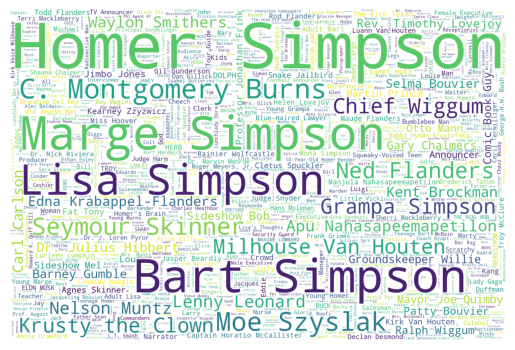

In [33]:
# Generate a word cloud for the characters' dialogue

# Extract the frequency of each character
characters = data['raw_character_text'].value_counts().to_dict()

# Initialize a WordCloud object with desired parameters
wc = WordCloud(width=1500, height=1000, max_words=1000, max_font_size=300,background_color='white', random_state=42)

# Generate the word cloud from the character frequencies
wc.generate_from_frequencies(characters)

# Display the word cloud
plt.imshow(wc)
plt.axis('off')
plt.show()

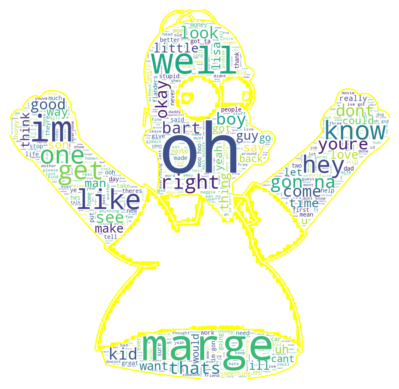

In [59]:
# Load the mask image for Homer Simpson
mask_homer = np.array(Image.open(r"C:\Users\user\OneDrive\Desktop\R.png"))

# Initialize a WordCloud object with desired parameters
wc = WordCloud(stopwords=stop_words, mask=mask_homer,max_words=2000,background_color="white", max_font_size=500, random_state=42,contour_width=3, contour_color='yellow',
               width=mask_homer.shape[1], height=mask_homer.shape[0])

# Generate the word cloud from Homer Simpson's dialogue
wc.generate(' '.join(character_scripts['Homer Simpson']))

# Display the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

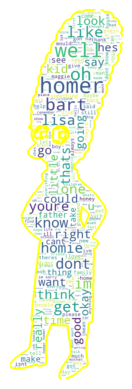

In [75]:
# Load the mask image for Marge Simpson
mask_marge = np.array(Image.open(r"C:\Users\user\OneDrive\Desktop\R 22.png"))

# Initialize a WordCloud object with desired parameters
wc = WordCloud(stopwords=stop_words, mask=mask_marge,max_words=2000, max_font_size=500, random_state=42,background_color="white",contour_width=5, contour_color='yellow',
               width=mask_marge.shape[1], height=mask_marge.shape[0])

# Generate the word cloud from Marge Simpson's dialogue
wc.generate(' '.join(character_scripts['Marge Simpson']))

# Display the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

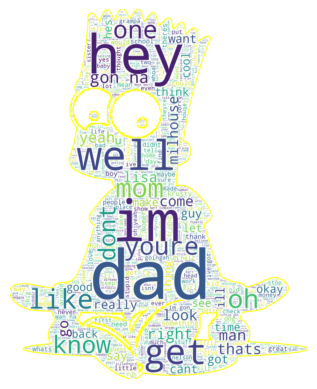

In [76]:
# Load the mask image for Bart Simpson
mask_bart = np.array(Image.open(r"C:\Users\user\OneDrive\Desktop\The-Simpsons-Character-PNG-Picture.png"))

# Initialize a WordCloud object with desired parameters
wc = WordCloud(stopwords=stop_words, mask=mask_bart,max_words=2000, max_font_size=500, random_state=42,background_color="white",contour_width=7, contour_color='yellow')

# Generate the word cloud from Bart Simpson's dialogue
wc.generate(' '.join(character_scripts['Bart Simpson']))

# Display the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


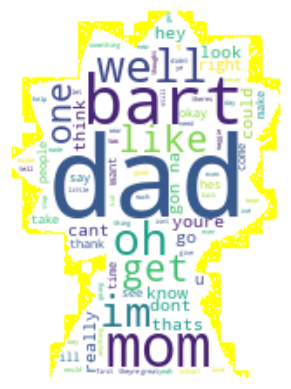

In [43]:
# Load the mask image for Lisa Simpson
mask_lisa= np.array(Image.open(r"C:\Users\user\OneDrive\Desktop\The Simpsons\lisa.jpeg"))

# Initialize a WordCloud object with desired parameters
wc = WordCloud(stopwords=stop_words, mask=mask_lisa,max_words=2000, max_font_size=500, random_state=42,background_color="white",contour_width=1, contour_color='yellow',
               width=mask_lisa.shape[1], height=mask_lisa.shape[0])

# Generate the word cloud from Lisa Simpson's dialogue
wc.generate(' '.join(character_scripts['Lisa Simpson']))

# Display the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()